In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input, concatenate, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
 # Loading the wind dataset
df = pd.read_csv("T1total_Cleaned.csv", index_col="TimeStamp", parse_dates=True)
df.head()
#Calculate Wind Speed cube for each row and create a new column named "WindSpeedCube"
df['WindSpeedCube'] = df['windspeed']**3

#Make last column to power 
df = df[["windspeed","winddirection","PitchAngle","temperature","WindSpeedCube","power"]]

df.head()


df.describe

#Function to create x,y components of wind speed
#function to create x,y component of wind direction 
def x_y_component(wind_direction, wind_speed):
    """Convert degrees to x,y components"""
#convert to radians     
    radians = (wind_direction * np.pi)/180
# give the x, y compenents     
    x = wind_speed * np.cos(radians)
    y = wind_speed * np.sin(radians)
    return x,y
# create two extra columns in raw_data_nm for x,y compnenents of wind direction df['x_com'], df['y_com'] = x_y_component(df['WindDirection'],                                                           df['WindSpeed'])
df.head()

# create two extra columns in raw_data_nm for x,y compnenents of wind direction 
df['x_com'], df['y_com'] = x_y_component(df['winddirection'],
                                         df['windspeed'])
df.head()
df["Hour"] = df.index.hour
df["DayOfWeek"] = df.index.dayofweek
df["Month"] = df.index.month
df.head ()
# Create rolling mean and standard deviation features for wind speed, temperature, and power
df['WindSpeedRollingMean'] = df['windspeed'].rolling(window=24).mean()
df['PowerRollingMean'] = df['power'].rolling(window=24).mean()

df.head()

#Nan değerleri sıfır yap
df = df.fillna(0)
df.isnull().sum()

#df nin bütün verilerini nümerik hale getir
df = df.apply(pd.to_numeric)
df.head()
#Hout, DayOfWeek, Month kolonlarını float yap
df['Hour'] = df['Hour'].astype(float)
df['DayOfWeek'] = df['DayOfWeek'].astype(float)
df['Month'] = df['Month'].astype(float)
df.dtypes
#Day of week, hour, month kolonlarının sinüs ve kosinüs değerlerini al
df['DayOfWeekSin'] = np.sin(df.DayOfWeek*(2.*np.pi/7))
df['DayOfWeekCos'] = np.cos(df.DayOfWeek*(2.*np.pi/7))
df['HourSin'] = np.sin(df.Hour*(2.*np.pi/24))
df['HourCos'] = np.cos(df.Hour*(2.*np.pi/24))
df['MonthSin'] = np.sin((df.Month-1)*(2.*np.pi/12))
df['MonthCos'] = np.cos((df.Month-1)*(2.*np.pi/12))
df.head()
def create_lag(df: pd.core.frame.DataFrame, column: str, lags: list) -> pd.core.frame.DataFrame:
    """
    Function that allows to create lagged features.

    Parameters
    ----------
    data : pd.core.frame.DataFrame
        Data which contains feature.
    
    column : str
        column to be transformed.
    
    lags : list
        Lag numbers.

    Returns
    -------
    pd.core.frame.DataFrame
        Lagged feature.

    """
    for lag in lags:
        df[column + "_lag_" + str(lag)] = df[column].shift(periods=lag).astype(np.float16)
    
    return df

df = create_lag(df=df, column="windspeed", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="winddirection", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="PitchAngle", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="power", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="x_com", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="y_com", lags=[1, 2, 3, 6])
df = create_lag(df=df, column="temperature", lags=[1, 2, 3, 6])
df.head()

,windspeed,winddirection,PitchAngle,temperature,WindSpeedCube,power,x_com,y_com,Hour,DayOfWeek,...,x_com_lag_3,x_com_lag_6,y_com_lag_1,y_com_lag_2,y_com_lag_3,y_com_lag_6,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_6
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,140.608,180.899994,-4.390506,2.786299,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:10:00,5.4,138.600006,-2.1,5.0,157.464,213.300003,-4.050600,3.571084,0.0,1.0,...,NaN,NaN,2.787109,NaN,NaN,NaN,5.0,NaN,NaN,NaN
2019-01-01 00:20:00,5.0,141.500000,-1.7,5.0,125.000,164.100006,-3.913041,3.112573,0.0,1.0,...,NaN,NaN,3.570312,2.787109,NaN,NaN,5.0,5.0,NaN,NaN
2019-01-01 00:30:00,3.5,132.000000,0.6,5.0,42.875,21.799999,-2.341957,2.601007,0.0,1.0,...,-4.390625,NaN,3.113281,3.570312,2.787109,NaN,5.0,5.0,5.0,NaN
2019-01-01 00:40:00,3.8,136.899994,0.0,5.0,54.872,48.299999,-2.774616,2.596441,0.0,1.0,...,-4.050781,NaN,2.601562,3.113281,3.570312,NaN,5.0,5.0,5.0,NaN


In [2]:
df.drop(["temperature_lag_6",
"windspeed_lag_3",
"y_com_lag_1",
"y_com_lag_2",
"Month",
"MonthCos",
"temperature_lag_1",
"winddirection_lag_6",
"windspeed_lag_6",
"y_com_lag_3",
"PitchAngle_lag_2",
"x_com_lag_6",
"Hour",
"temperature_lag_2",
"temperature_lag_3",
"winddirection_lag_1",
"x_com_lag_3",
"y_com_lag_6",
"DayOfWeekSin",
"winddirection_lag_2",
"x_com_lag_2",
"DayOfWeek",
"DayOfWeekCos",
"HourSin",
"PitchAngle_lag_3",
"PitchAngle_lag_6",
"winddirection_lag_3",
], axis=1, inplace=True)
df.head()

,windspeed,winddirection,PitchAngle,temperature,WindSpeedCube,power,x_com,y_com,WindSpeedRollingMean,PowerRollingMean,HourCos,MonthSin,windspeed_lag_1,windspeed_lag_2,PitchAngle_lag_1,power_lag_1,power_lag_2,power_lag_3,power_lag_6,x_com_lag_1
TimeStamp,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,5.2,147.600006,-1.8,5.0,140.608,180.899994,-4.390506,2.786299,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:10:00,5.4,138.600006,-2.1,5.0,157.464,213.300003,-4.050600,3.571084,0.0,0.0,1.0,0.0,5.199219,NaN,-1.799805,180.875000,NaN,NaN,NaN,-4.390625
2019-01-01 00:20:00,5.0,141.500000,-1.7,5.0,125.000,164.100006,-3.913041,3.112573,0.0,0.0,1.0,0.0,5.398438,5.199219,-2.099609,213.250000,180.875,NaN,NaN,-4.050781
2019-01-01 00:30:00,3.5,132.000000,0.6,5.0,42.875,21.799999,-2.341957,2.601007,0.0,0.0,1.0,0.0,5.000000,5.398438,-1.700195,164.125000,213.250,180.875,NaN,-3.912109
2019-01-01 00:40:00,3.8,136.899994,0.0,5.0,54.872,48.299999,-2.774616,2.596441,0.0,0.0,1.0,0.0,3.500000,5.000000,0.600098,21.796875,164.125,213.250,NaN,-2.341797


In [3]:
# negatif power değerlerini 0 yap
df.loc[df.power < 0, 'power'] = 0

In [4]:
df.fillna(0, inplace=True)

In [5]:
df = df[['power','windspeed', 'winddirection', 'PitchAngle', 'WindSpeedCube']]

# df = df[['power','windspeed', 'winddirection', 'PitchAngle', 'WindSpeedCube',
#        'windspeed_lag_1', 'windspeed_lag_2',
#        'power_lag_1', 'power_lag_2', 'power_lag_3', 'power_lag_6',
#        ]]

In [6]:
validate = df[['power','windspeed', 'winddirection', 'PitchAngle', 'WindSpeedCube']].tail(4)

# validate = df[['power','windspeed', 'winddirection', 'PitchAngle', 'WindSpeedCube',
#        'windspeed_lag_1', 'windspeed_lag_2',
#        'power_lag_1', 'power_lag_2', 'power_lag_3', 'power_lag_6',
#        ]].tail(3)

df.drop(df.tail(4).index,inplace=True)

In [7]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end, horizon-1):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i, i+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y) 

In [8]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
Y_scaler = MinMaxScaler(feature_range=(0, 1))

X_data = X_scaler.fit_transform(df)
Y_data = Y_scaler.fit_transform(df['power'].values.reshape(-1, 1))

In [9]:
hist_window = 72
horizon = 4
TRAIN_SPLIT = int(len(df) * 0.8)

x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon) 

In [10]:
print ('Multiple window of past history\n')
print(x_train[0])
print ('\n Target horizon\n')
print (y_train[0]) 

Multiple window of past history

[[0.0602799  0.21399178 0.14927969 0.01849837 0.00979921]
 [0.07107631 0.22222223 0.14017727 0.01523395 0.01097394]
 [0.05468177 0.20576133 0.14311026 0.01958651 0.00871147]
 [0.00726424 0.14403293 0.13350215 0.04461371 0.00298803]
 [0.01609463 0.15637861 0.13845791 0.03808487 0.00382412]
 [0.02235921 0.17695474 0.13805336 0.03155604 0.00554098]
 [0.02645785 0.17283951 0.14786374 0.03155604 0.00516332]
 [0.038987   0.19341565 0.14543644 0.0250272  0.0072356 ]
 [0.03958681 0.19341565 0.1402784  0.02285092 0.0072356 ]
 [0.04955015 0.19753087 0.1402784  0.02285092 0.00770735]
 [0.04935022 0.19753087 0.13946929 0.02176279 0.00770735]
 [0.04968344 0.2016461  0.14048067 0.02067465 0.00819916]
 [0.04811729 0.19753087 0.14250343 0.02285092 0.00770735]
 [0.03445518 0.18518519 0.13400784 0.02611534 0.00635066]
 [0.03578807 0.18106997 0.13694084 0.02829162 0.00593662]
 [0.07087637 0.218107   0.13805336 0.01632209 0.0103755 ]
 [0.10216595 0.24279836 0.1179269  0.01

In [11]:
from tensorflow.data import Dataset

batch_size = 256
buffer_size = 150
train_data = Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size)
val_data = Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Modeli oluşturma
model = Sequential([
    GRU(384, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    Dropout(0.5),
    GRU(384, return_sequences=False),
    Dropout(0.5),
    Dense(4, activation='linear') 
])

# Modeli derleme
optimizer = Adam(lr=0.0028115)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Model özeti
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 72, 384)           450432    
                                                                 
 dropout (Dropout)           (None, 72, 384)           0         
                                                                 
 gru_1 (GRU)                 (None, 384)               887040    
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense (Dense)               (None, 4)                 1540      
                                                                 
Total params: 1339012 (5.11 MB)
Trainable params: 1339012 (5.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
EarlyStopping = EarlyStopping(monitor='val_loss', patience=10)
ModelCheckpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

model_history = model.fit(train_data, validation_data=(val_data) ,epochs=4, verbose=1 ,callbacks=[EarlyStopping, ModelCheckpoint])

Epoch 1/4



201/201 [==============================] - 165s 794ms/step - loss: 0.0117 - val_loss: 0.0095
Epoch 2/4


C:\Users\onyxe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


201/201 [==============================] - 159s 793ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 3/4
201/201 [==============================] - 158s 786ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 4/4
201/201 [==============================] - 159s 790ms/step - loss: 0.0084 - val_loss: 0.0093


In [14]:
model.load_weights('model.h5')

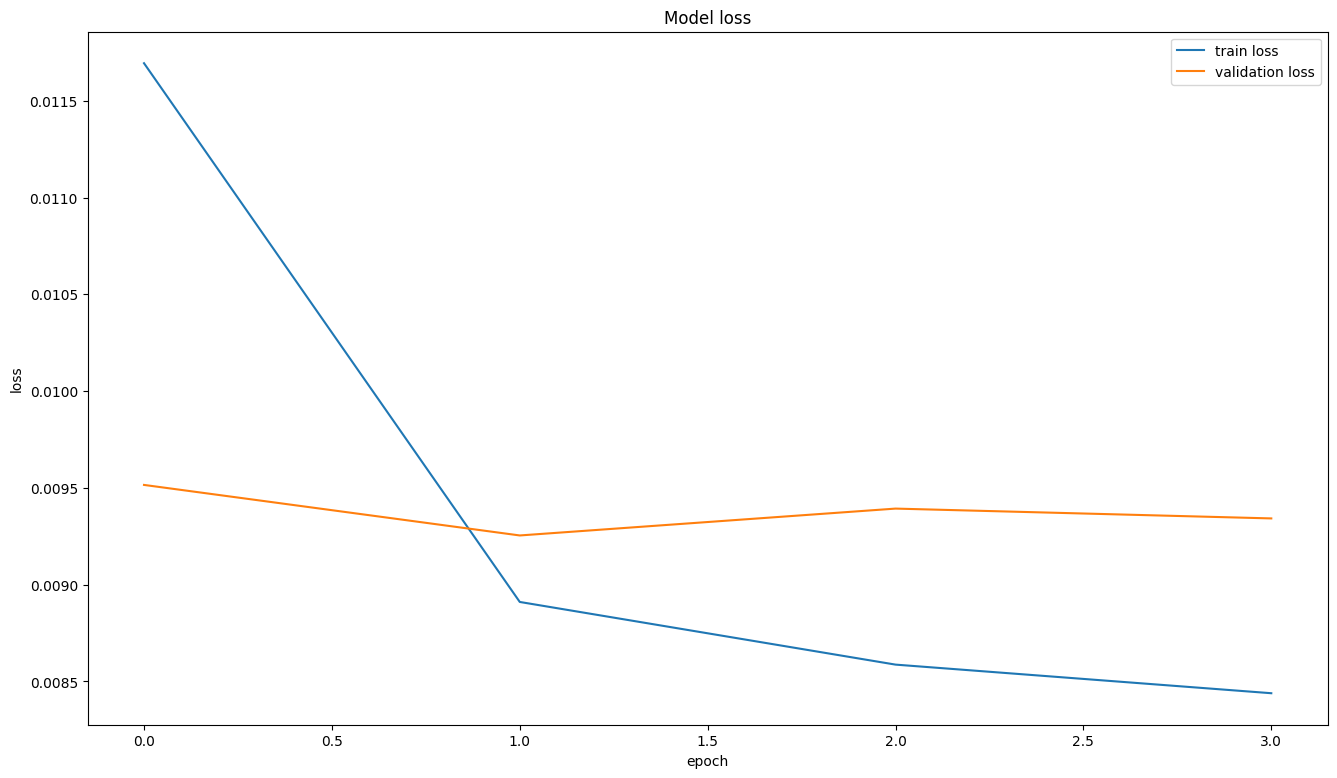

In [15]:
plt.figure(figsize=(16,9))
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

In [16]:
# from keras.models import load_model
# model = load_model('best_model.h5')
# model.summary()

In [17]:
# Tahmin yapmak istediğiniz zaman aralığını seçin, örneğin son 72 adım
data_val = X_scaler.transform(df[-72:])

# Modelin beklediği formata getirin
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

# Tahmin yapın
pred = model.predict(val_rescaled)

# Tahminleri geri ölçeklendirin
pred_Inverse = Y_scaler.inverse_transform(pred)


1/1 [==============================] - 1s 1s/step


In [18]:
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

array([[492.58557, 509.6977 , 491.25903, 510.21585]], dtype=float32)

In [19]:
validate.reset_index(inplace=True)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def timeseries_evaluation_metrics_func(y_true, y_pred):
     def mean_absolute_percentage_error(y_true, y_pred): 
         y_true, y_pred = np.array(y_true), np.array(y_pred)
         return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
     print('Evaluation metric results:-')
     print(f'MSE is : {mean_squared_error(y_true, y_pred)}')
     print(f'MAE is : {mean_absolute_error(y_true, y_pred)}')
     print(f'RMSE is : {np.sqrt(mean_squared_error(y_true, y_pred))}')
     print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
     print(f'R2 is : {r2_score(y_true, y_pred)}',end='\n\n') 

In [21]:
timeseries_evaluation_metrics_func(validate['power'],pred_Inverse[0])

Evaluation metric results:-
MSE is : 33822.97922935348
MAE is : 181.46453104833984
RMSE is : 183.91024775513048
MAPE is : 58.58665998095732
R2 is : -28.662725731656575



401/401 [==============================] - 26s 64ms/step


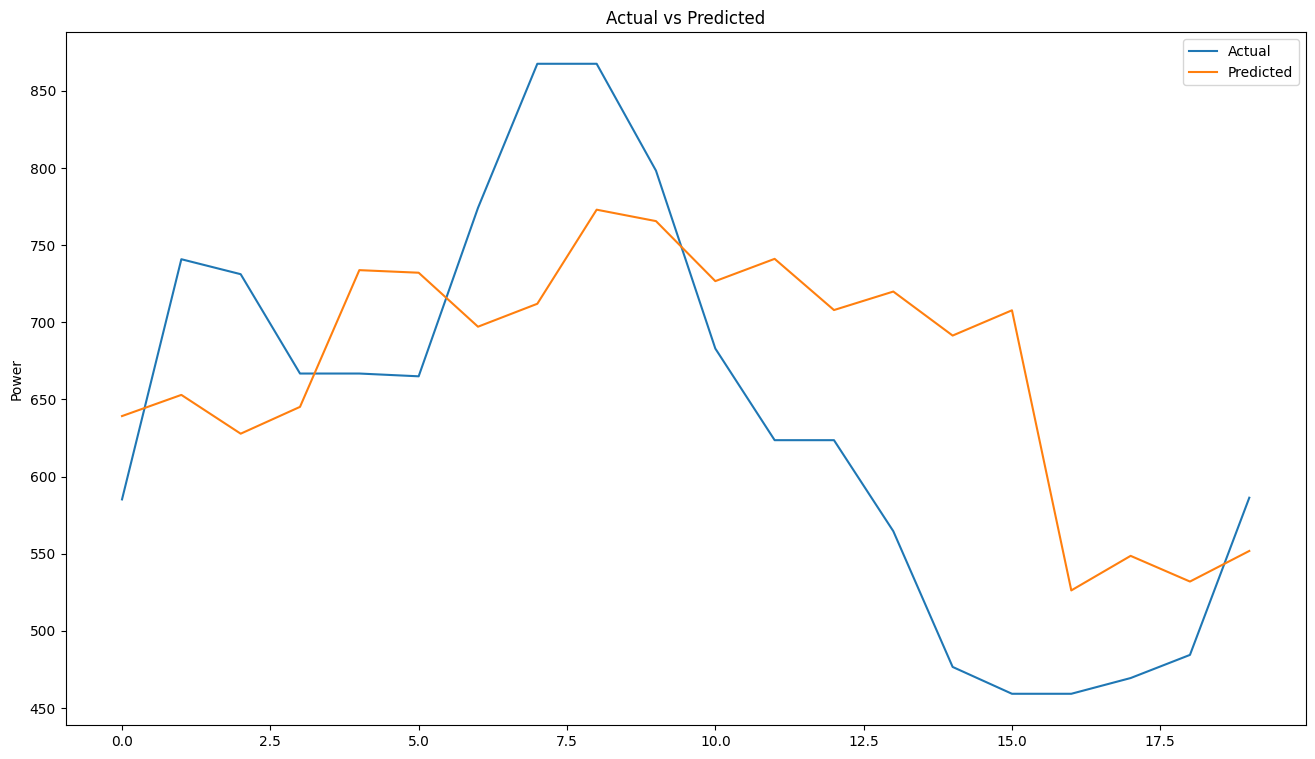

In [22]:
pred = model.predict(x_vali)
pred_Inverse = Y_scaler.inverse_transform(pred)
y_vali_Inverse = Y_scaler.inverse_transform(y_vali.reshape(y_vali.shape[0], y_vali.shape[1] * y_vali.shape[2]))

minutes = -20

plt.figure(figsize=(16,9))
plt.plot(y_vali_Inverse.flatten()[minutes:], label='Actual')
plt.plot(pred_Inverse.flatten()[minutes:], label='Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Power')
plt.legend()
plt.show()